In [1]:
import sys
import os
# Add the project root directory to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F

from src.data_processing.dataset_builder import preprocess_data

from src.modeling.trainer_without_attention import *
from src.modeling.modeling import GUTNetConfig, GUTNetForSequenceClassification


e:\Anaconda\envs\lf\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### prepare dataloader for mlp and multi-logistic regression

In [3]:
data_path = os.path.join(project_root, 'data', 'standardized')
# dataloader for training mlp : batch_szie = 512
train_dataloader, valid_dataloader, test_dataloader = preprocess_data(data_path, batch_size = 512).get_dataloader()
# dataloader for training multi-logistic regression and validating and testing  : batch_szie = len(dataset)
logi_train_dataloader, logi_valid_dataloader, logi_test_dataloader = preprocess_data(data_path).get_dataloader()

### make a quick fetch of dataloader.
def get_one(x): return next(iter(x))


No overlap between train and valid datasets.
No overlap between train and test datasets.
No overlap between valid and test datasets.

Label distribution:
Label     Train     Valid     Test      
----------------------------------------
0         1296      280       264       
1         1334      290       296       
2         11261     2419      2425      
3         669       131       135       

Total samples:
Train     14560     
Valid     3120      
Test      3120      
No overlap between train and valid datasets.
No overlap between train and test datasets.
No overlap between valid and test datasets.

Label distribution:
Label     Train     Valid     Test      
----------------------------------------
0         1296      280       264       
1         1334      290       296       
2         11261     2419      2425      
3         669       131       135       

Total samples:
Train     14560     
Valid     3120      
Test      3120      


### train logistic regression

In [4]:
logi_re = LogisticRegression(penalty='l2')

In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Train model
x, y = get_one(logi_train_dataloader)
logi_re.fit(x, y)

# Get predictions
valid_x, valid_y = get_one(logi_valid_dataloader)
pred_valid_y = logi_re.predict(valid_x)
pred_valid_proba = logi_re.predict_proba(valid_x)

test_x, test_y = get_one(logi_test_dataloader)
pred_test_y = logi_re.predict(test_x)
pred_test_proba = logi_re.predict_proba(test_x)

# Calculate accuracy scores
valid_score = accuracy_score(valid_y, pred_valid_y)
test_score = accuracy_score(test_y, pred_test_y)
print(f'valid_accuracy_score : {valid_score}, test_accuracy_score : {test_score}')



valid_accuracy_score : 0.570790605358915, test_accuracy_score : 0.567398119122257


e:\Anaconda\envs\lf\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Visualization

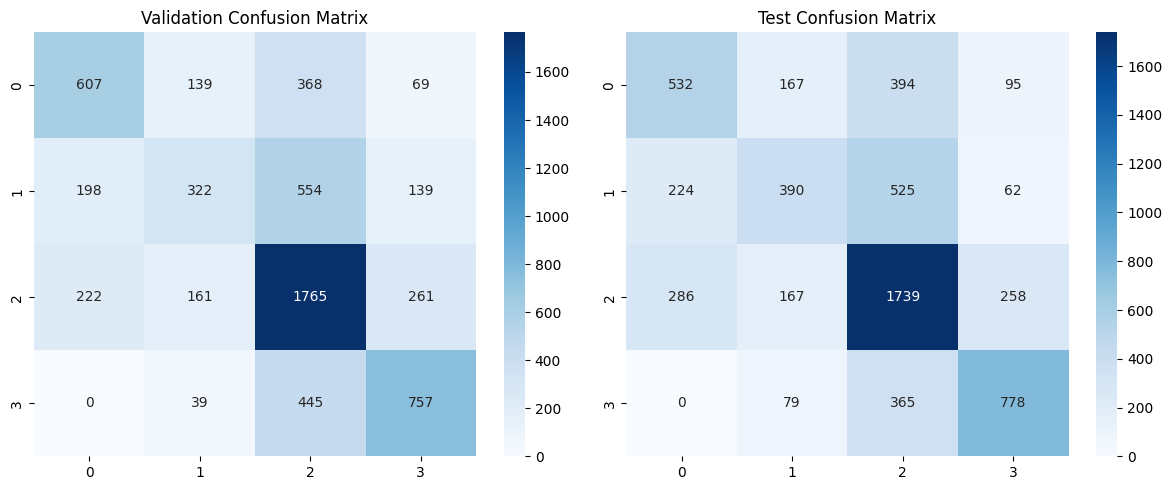

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

In [6]:
# Plot confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.heatmap(confusion_matrix(valid_y, pred_valid_y), annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix')
plt.subplot(122)
sns.heatmap(confusion_matrix(test_y, pred_test_y), annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.tight_layout()
plt.show()

# Plot ROC curves
n_classes = len(np.unique(y))
valid_y_bin = label_binarize(valid_y, classes=range(n_classes))
test_y_bin = label_binarize(test_y, classes=range(n_classes))

plt.figure(figsize=(12, 5))



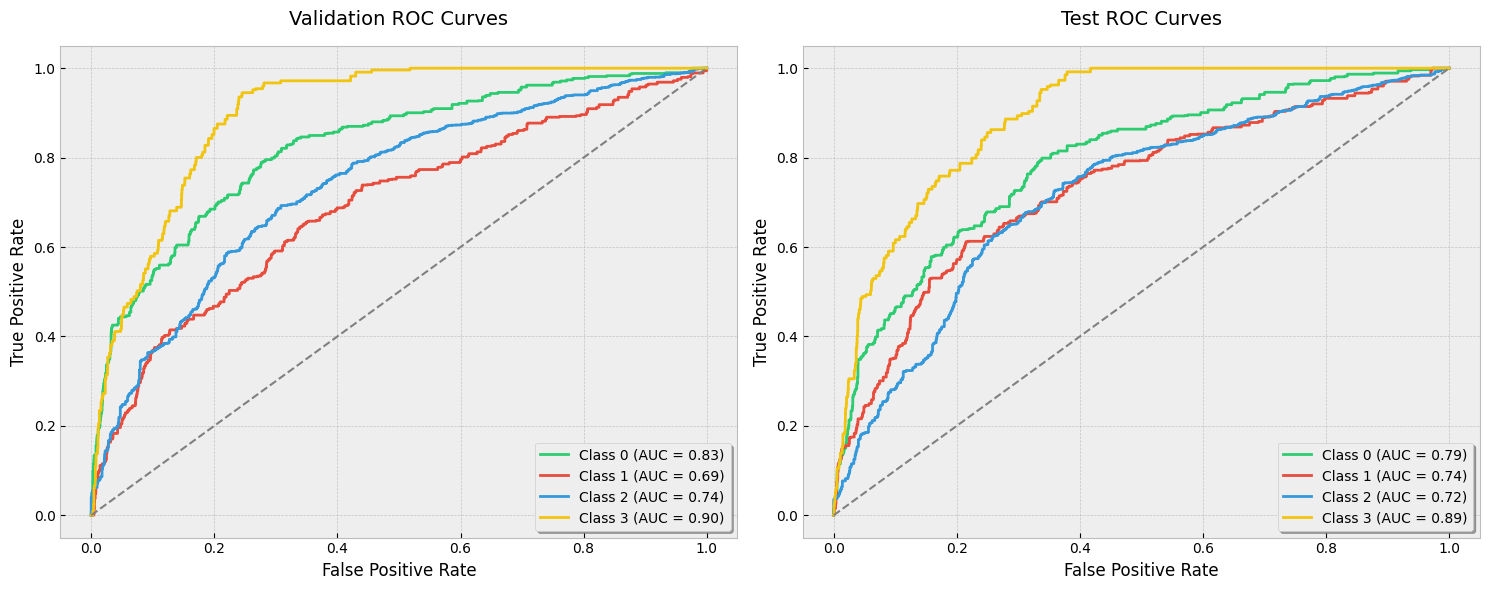

In [7]:
# Set style
plt.style.use('bmh')  # 使用内置的 bmh 样式，它提供了类似 seaborn 的美观效果
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Custom colors and line styles
colors = ['#2ecc71', '#e74c3c', '#3498db', '#f1c40f']
line_width = 2

# Validation ROC
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(valid_y_bin[:, i], pred_valid_proba[:, i])
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, color=colors[i], lw=line_width, 
             label=f'Class {i} (AUC = {roc_auc:.2f})')

ax1.plot([0, 1], [0, 1], '--', color='gray', lw=1.5)
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('Validation ROC Curves', fontsize=14, pad=15)
ax1.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)
ax1.grid(True, linestyle='--', alpha=0.7)

# Test ROC
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_y_bin[:, i], pred_test_proba[:, i])
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color=colors[i], lw=line_width,
             label=f'Class {i} (AUC = {roc_auc:.2f})')

ax2.plot([0, 1], [0, 1], '--', color='gray', lw=1.5)
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('Test ROC Curves', fontsize=14, pad=15)
ax2.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)
ax2.grid(True, linestyle='--', alpha=0.7)

# Overall layout
plt.tight_layout()
plt.show()

### construct a MLP for classification

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(11, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 4)
            )
    def forward(self, x):
        return self.seq(x)

### train MLP and evaluate

In [9]:
# 训练设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loss_list = []
valid_loss_list = []
test_loss_list = []
model = MLP().to(device)
model_loss = nn.CrossEntropyLoss()
model_optizer = torch.optim.AdamW(model.parameters(), lr=0.01)

def valid_mlp_model(model):
    model.eval()
    with torch.no_grad():
        x, y = get_one(valid_dataloader)
        x, y = x.to(device), y.to(device).long()  # Convert labels to long
        y_pre = model(x)
        loss = model_loss(y_pre, y)
        return loss.item()

def train_mlp_model(model, epoch=2000, patience=200):
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(1, epoch + 1):
        x, y = get_one(train_dataloader)
        x, y = x.to(device), y.to(device).long()  # Convert labels to long
        
        # 训练步骤
        model_optizer.zero_grad()
        y_pre = model(x)
        loss = model_loss(y_pre, y)
        loss.backward()
        model_optizer.step()
        
        # 验证步骤
        valid_loss = valid_mlp_model(model)
        
        # 记录损失
        train_loss_list.append(loss.cpu().detach().numpy())
        valid_loss_list.append(valid_loss)
        
        print(f'Epoch: {epoch}, train_Loss: {loss.item():.4f}, valid_Loss: {valid_loss:.4f}')
        
        # 早停逻辑
        if valid_loss < best_loss:
            best_loss = valid_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch} epochs')
            print(f'Best validation loss: {best_loss:.4f}')
            model.load_state_dict(best_model_state)
            break

def evaluate_model(model):
    model.eval()
    with torch.no_grad():
        # 验证集评估
        valid_x, valid_y = get_one(valid_dataloader)
        valid_x, valid_y = valid_x.to(device), valid_y.to(device).long()  # Convert labels to long
        pred_valid_y = model(valid_x)
        valid_pred = torch.max(F.softmax(pred_valid_y, dim=1), 1)[1]
        valid_score = accuracy_score(valid_y.cpu(), valid_pred.cpu())
        
        # 测试集评估
        test_x, test_y = get_one(test_dataloader)
        test_x, test_y = test_x.to(device), test_y.to(device).long()  # Convert labels to long
        pred_test_y = model(test_x)
        test_pred = torch.max(F.softmax(pred_test_y, dim=1), 1)[1]
        test_score = accuracy_score(test_y.cpu(), test_pred.cpu())
        
        print(f'Validation accuracy: {valid_score:.4f}')
        print(f'Test accuracy: {test_score:.4f}')
        
        # 混淆矩阵可视化
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        sns.heatmap(confusion_matrix(valid_y.cpu(), valid_pred.cpu()), 
                    annot=True, fmt='d', cmap='Blues')
        plt.title('Validation Confusion Matrix')
        
        plt.subplot(1, 2, 2)
        sns.heatmap(confusion_matrix(test_y.cpu(), test_pred.cpu()), 
                    annot=True, fmt='d', cmap='Blues')
        plt.title('Test Confusion Matrix')
        
        plt.tight_layout()
        plt.show()
        
        # 绘制AUC曲线
        plot_auc_curve(test_y.cpu(), F.softmax(pred_test_y, dim=1).cpu())

def plot_training_history():
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Training Loss')
    plt.title('Training Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(valid_loss_list, label='Validation Loss')
    plt.title('Validation Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_auc_curve(y_true, y_score):
    # 获取类别数量
    n_classes = y_score.shape[1]

    # 将标签进行one-hot编码
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    # 计算每个类别的ROC曲线和AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 绘制所有ROC曲线
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


In [10]:
train_mlp_model(model)


Epoch: 1, train_Loss: 1.5937, valid_Loss: 1.4525
Epoch: 2, train_Loss: 1.4875, valid_Loss: 1.3346
Epoch: 3, train_Loss: 1.3264, valid_Loss: 1.3286
Epoch: 4, train_Loss: 1.2698, valid_Loss: 1.2959
Epoch: 5, train_Loss: 1.2953, valid_Loss: 1.2347
Epoch: 6, train_Loss: 1.2295, valid_Loss: 1.2792
Epoch: 7, train_Loss: 1.2378, valid_Loss: 1.2763
Epoch: 8, train_Loss: 1.1672, valid_Loss: 1.2517
Epoch: 9, train_Loss: 1.1901, valid_Loss: 1.1988
Epoch: 10, train_Loss: 1.1322, valid_Loss: 1.1702
Epoch: 11, train_Loss: 1.1336, valid_Loss: 1.1536
Epoch: 12, train_Loss: 1.1072, valid_Loss: 1.1868
Epoch: 13, train_Loss: 1.1193, valid_Loss: 1.1403
Epoch: 14, train_Loss: 1.0996, valid_Loss: 1.1507
Epoch: 15, train_Loss: 1.1354, valid_Loss: 1.1771
Epoch: 16, train_Loss: 1.0703, valid_Loss: 1.0444
Epoch: 17, train_Loss: 1.0800, valid_Loss: 1.0772
Epoch: 18, train_Loss: 1.0871, valid_Loss: 1.0702
Epoch: 19, train_Loss: 1.0308, valid_Loss: 1.0965
Epoch: 20, train_Loss: 0.9998, valid_Loss: 1.0137
Epoch: 21

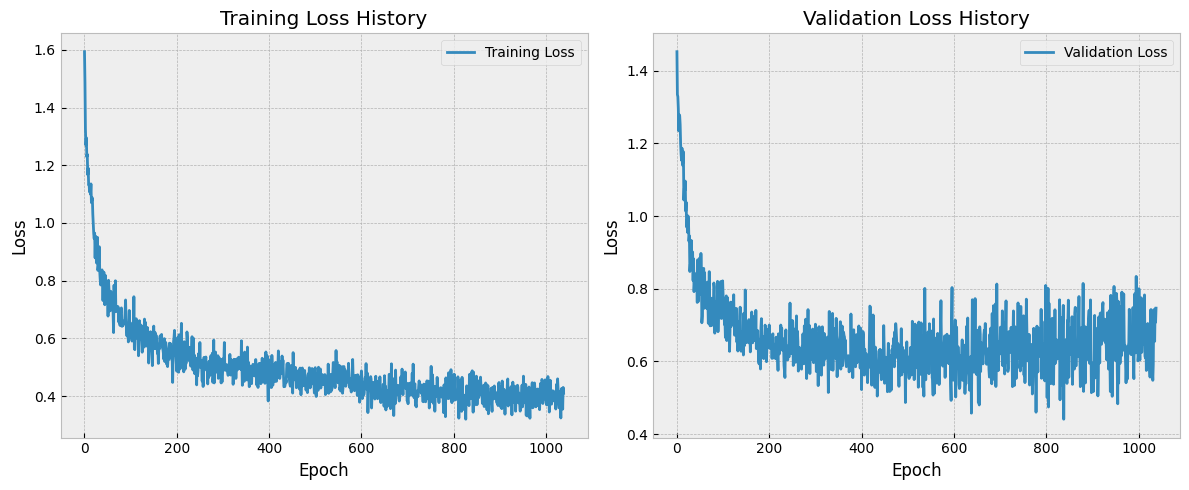

In [11]:
plot_training_history()

Validation accuracy: 0.7852
Test accuracy: 0.8203


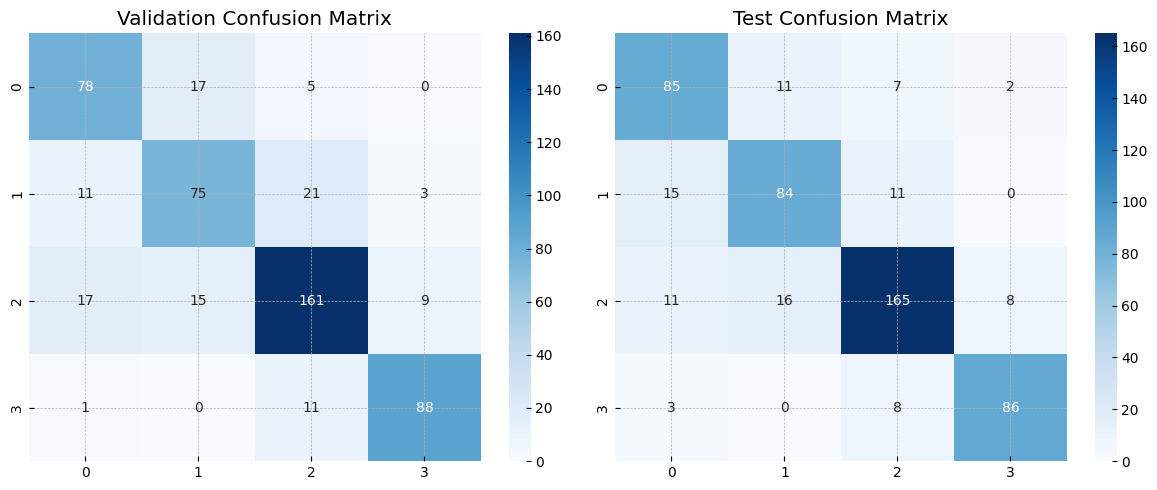

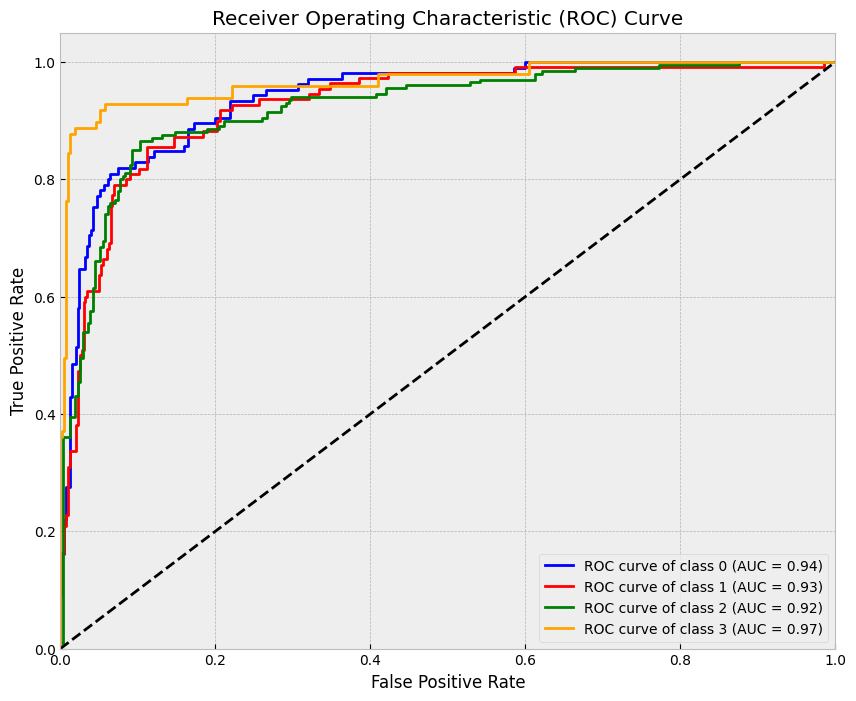

In [12]:
evaluate_model(model)

Using device: cuda
No overlap between train and valid datasets.
No overlap between train and test datasets.
No overlap between valid and test datasets.

Label distribution:
Label     Train     Valid     Test      
----------------------------------------
0         1296      280       264       
1         1334      290       296       
2         11261     2419      2425      
3         669       131       135       

Total samples:
Train     14560     
Valid     3120      
Test      3120      
Batch 0 - Input shape: torch.Size([768, 11]), Labels shape: torch.Size([768])
Batch 0 - Labels min: 0, max: 3
Batch 0 - Unique labels: tensor([0, 1, 2, 3], dtype=torch.int32)
Batch 1 - Input shape: torch.Size([768, 11]), Labels shape: torch.Size([768])
Batch 1 - Labels min: 0, max: 3
Batch 1 - Unique labels: tensor([0, 1, 2, 3], dtype=torch.int32)
Batch 2 - Input shape: torch.Size([768, 11]), Labels shape: torch.Size([768])
Batch 2 - Labels min: 0, max: 3
Batch 2 - Unique labels: tensor([0, 1, 2, 

Epoch 1/100:   0%|          | 0/37 [00:00<?, ?it/s]

Input shape in GUTNetForSequenceClassification: torch.Size([768, 11])
Input shape in GUTNet: torch.Size([768, 11])
Embedding output shape: torch.Size([768, 1, 258])
Hidden states shape in self-attention: torch.Size([768, 1, 258])
Hidden states shape in self-attention: torch.Size([768, 1, 258])
Hidden states shape in self-attention: torch.Size([768, 1, 258])
Hidden states shape in self-attention: torch.Size([768, 1, 258])
Hidden states shape in self-attention: torch.Size([768, 1, 258])
Hidden states shape in self-attention: torch.Size([768, 1, 258])
Pooled output shape: torch.Size([768, 258])
Pooled output shape: torch.Size([768, 258])
Logits shape: torch.Size([768, 5])


Epoch 1/100: 100%|██████████| 37/37 [00:00<00:00, 42.41it/s, loss=0.9972]
INFO:src.modeling.trainer_without_attention:Epoch 1/100
INFO:src.modeling.trainer_without_attention:Train Loss: 1.1232, Train Acc: 0.5162
INFO:src.modeling.trainer_without_attention:Val Loss: 0.9650, Val Acc: 0.6259
Epoch 2/100: 100%|██████████| 37/37 [00:00<00:00, 63.05it/s, loss=0.7812]
INFO:src.modeling.trainer_without_attention:Epoch 2/100
INFO:src.modeling.trainer_without_attention:Train Loss: 0.9090, Train Acc: 0.6321
INFO:src.modeling.trainer_without_attention:Val Loss: 0.8864, Val Acc: 0.6358
Epoch 3/100: 100%|██████████| 37/37 [00:00<00:00, 54.21it/s, loss=0.6877]
INFO:src.modeling.trainer_without_attention:Epoch 3/100
INFO:src.modeling.trainer_without_attention:Train Loss: 0.7732, Train Acc: 0.6960
INFO:src.modeling.trainer_without_attention:Val Loss: 0.7589, Val Acc: 0.6818
Epoch 4/100: 100%|██████████| 37/37 [00:00<00:00, 64.28it/s, loss=0.6159]
INFO:src.modeling.trainer_without_attention:Epoch 4/100


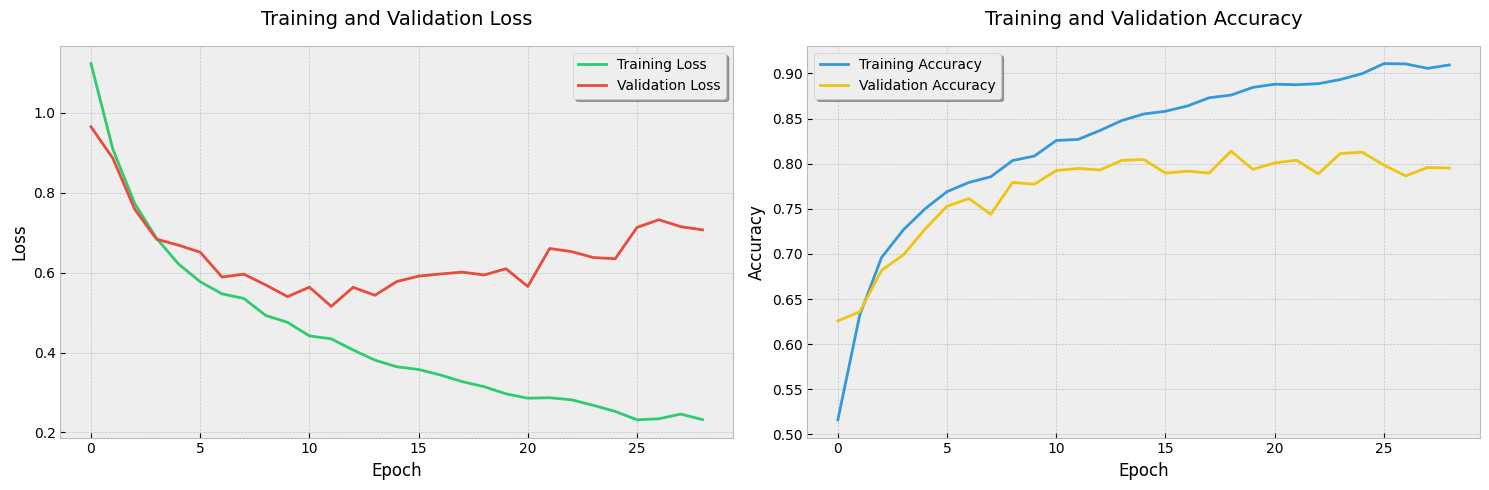

In [16]:
data_path = r'D:\毕业论文\zzy\gut_net_project\data\standardized'
input_dim = 11  # This is correct as your input shape is [128, 11]
num_classes = 5 
hidden_size = 258
num_hidden_layers = 6
num_attention_heads = 2
intermediate_size = 1024
hidden_dropout_prob = 0.05
attention_probs_dropout_prob = 0.3
batch_size = 
network_type = 'without_attention'


# Create configuration
config = GUTNetConfig(
    input_dim=input_dim,
    num_classes=num_classes, 
    hidden_size=hidden_size,
    num_hidden_layers=num_hidden_layers,
    num_attention_heads=num_attention_heads,
    intermediate_size=intermediate_size,
    hidden_dropout_prob=hidden_dropout_prob,
    attention_probs_dropout_prob=attention_probs_dropout_prob,
    problem_type="single_label_classification",
    log_level="INFO"
)

# 初始化训练器
trainer = GUTNetTrainer(config, data_path, batch_size=batch_size)

# 训练模型
trainer.train(num_epochs=100, patience=10)

# 加载最佳模型
trainer.model.load_state_dict(torch.load('best_model.pth'))

# 在测试集上评估
test_accuracy = trainer.evaluate(trainer.test_loader)
logger.info(f"测试准确率: {test_accuracy:.4f}")

# 在验证集上评估
val_accuracy = trainer.evaluate(trainer.val_loader)
logger.info(f"验证准确率: {val_accuracy:.4f}")

# 生成详细的评估报告
test_accuracy, test_report = trainer.generate_evaluation_report(trainer.test_loader)
val_accuracy, val_report = trainer.generate_evaluation_report(trainer.val_loader)

logger.info("\n测试集详细评估报告:")
logger.info(f"准确率: {test_accuracy:.4f}")
logger.info(f"分类报告:\n{test_report}")

logger.info("\n验证集详细评估报告:")
logger.info(f"准确率: {val_accuracy:.4f}")
logger.info(f"分类报告:\n{val_report}")

def plot_training_metrics(trainer):
    """
    Plot training and validation loss/accuracy curves
    """
    # Set style to a built-in matplotlib style
    plt.style.use('bmh')  # 使用内置的 bmh 样式，它提供了类似 seaborn 的美观效果
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss curves
    ax1.plot(trainer.train_losses, label='Training Loss', color='#2ecc71')
    ax1.plot(trainer.val_losses, label='Validation Loss', color='#e74c3c')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, pad=15)
    ax1.legend(frameon=True, fancybox=True, shadow=True)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Plot accuracy curves
    ax2.plot(trainer.train_accuracies, label='Training Accuracy', color='#3498db')
    ax2.plot(trainer.val_accuracies, label='Validation Accuracy', color='#f1c40f')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, pad=15)
    ax2.legend(frameon=True, fancybox=True, shadow=True)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Call the plotting function after training
plot_training_metrics(trainer)

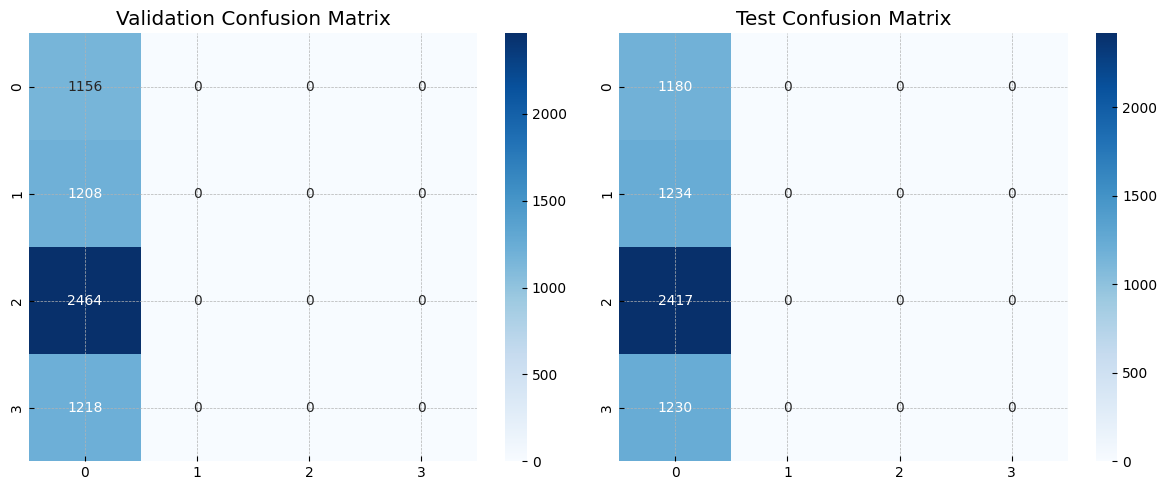

ValueError: Input contains NaN.

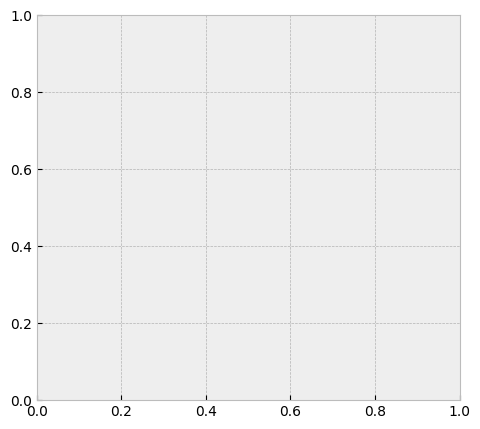

In [14]:
def plot_evaluation_visualizations(trainer, val_loader, test_loader):
    device = trainer.device
    model = trainer.model
    model.eval()
    
    # Get predictions for validation and test sets
    def get_predictions(loader):
        all_preds = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for batch in loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                outputs = model(inputs)
                # Access the logits from the SequenceClassifierOutput object
                logits = outputs.logits
                probs = F.softmax(logits, dim=1)
                preds = torch.argmax(probs, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())
                all_probs.extend(probs.cpu().numpy())
                
        return np.array(all_labels), np.array(all_preds), np.array(all_probs)

    # Get predictions
    val_labels, val_preds, val_probs = get_predictions(val_loader)
    test_labels, test_preds, test_probs = get_predictions(test_loader)

    # Plot confusion matrices
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    sns.heatmap(confusion_matrix(val_labels, val_preds), 
                annot=True, fmt='d', cmap='Blues')
    plt.title('Validation Confusion Matrix')
    
    plt.subplot(122)
    sns.heatmap(confusion_matrix(test_labels, test_preds), 
                annot=True, fmt='d', cmap='Blues')
    plt.title('Test Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Plot ROC curves
    plt.figure(figsize=(12, 5))
    
    # Validation ROC
    plt.subplot(121)
    val_bin_labels = label_binarize(val_labels, classes=range(num_classes))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(val_bin_labels[:, i], val_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Validation ROC Curves')
    plt.legend()
    
    # Test ROC
    plt.subplot(122)
    test_bin_labels = label_binarize(test_labels, classes=range(num_classes))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(test_bin_labels[:, i], test_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test ROC Curves')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the visualization function
plot_evaluation_visualizations(trainer, trainer.val_loader, trainer.test_loader)